In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import glob
import itertools
import os

from run import Run
from runs_db import db as runs_db

[('martak', 89), ('gcp', 57), ('deepnet2', 38), ('acer', 6)]


In [2]:
log_path = '/home/fiit/logs'
runs = []

for server in runs_db:
    paths = glob.glob(os.path.join(log_path, server, '*'))
    paths = iter(sorted(paths))

    try:
        for (number, type_, code) in runs_db[server]:
            for _ in range(number):
                try:
                    path = next(paths)
                    runs.append(Run(path, type_, code))
                except KeyError:
                    print(path)
    except StopIteration:
        pass


/home/fiit/logs/deepnet2/2019-02-18-182400


In [3]:
tasks = ['dep', 'lmo', 'ner', 'pos']
langs = ['cs', 'de', 'en', 'es']

task_metr = {
    'dep': 'las',
    'lmo': 'perplexity',
    'ner': 'chunk_f1',
    'pos': 'acc'
}

task_max = {
    'dep': True,
    'lmo': False,
    'ner': True,
    'pos': True
}

def draw_graphs(metric_func, tasks, langs, role, run_codes=None, run_types=None):
    fig, axes = plt.subplots(len(tasks), len(langs), figsize=(5*len(langs), 4*len(tasks)), squeeze=False)

    relevant_runs = ['vanilla']

    for task, lang in itertools.product(tasks, langs):
        for run in runs:
            if (
                run.contains(task, lang) and
                (run_codes is None or run.code in run_codes) and
                (run_types is None or run.type in run_types)
            ):

                history = run.history(
                    metric=metric_func(task),
                    task=task,
                    language=lang,
                    role=role)
                axes[tasks.index(task), langs.index(lang)].plot(list(history), label=f'{run.code}-{run.type}')

    for ax, col in zip(axes[0], langs):
        ax.set_title(col)

    for ax, row in zip(axes[:, 0], tasks):
        ax.set_ylabel(row, rotation=0, size='large')
        
    for ax_row in axes:
        for ax in ax_row:
            ax.legend()

    plt.show()
    
def print_results(metric_func, metric_max_func, tasks, langs, run_codes=None, run_types=None):
    
    for task, lang in itertools.product(tasks, langs):
        for run in runs:
            if (
                run.contains(task, lang) and
                (run_codes is None or run.code in run_codes) and
                (run_types is None or run.type in run_types)
            ):
                result = run.metric_eval(
                    metric=metric_func(task),
                    max_=metric_max_func(task),
                    task=task,
                    language=lang)
                print(f'{run.code} {run.type} {task} {lang}: {result}')
        

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


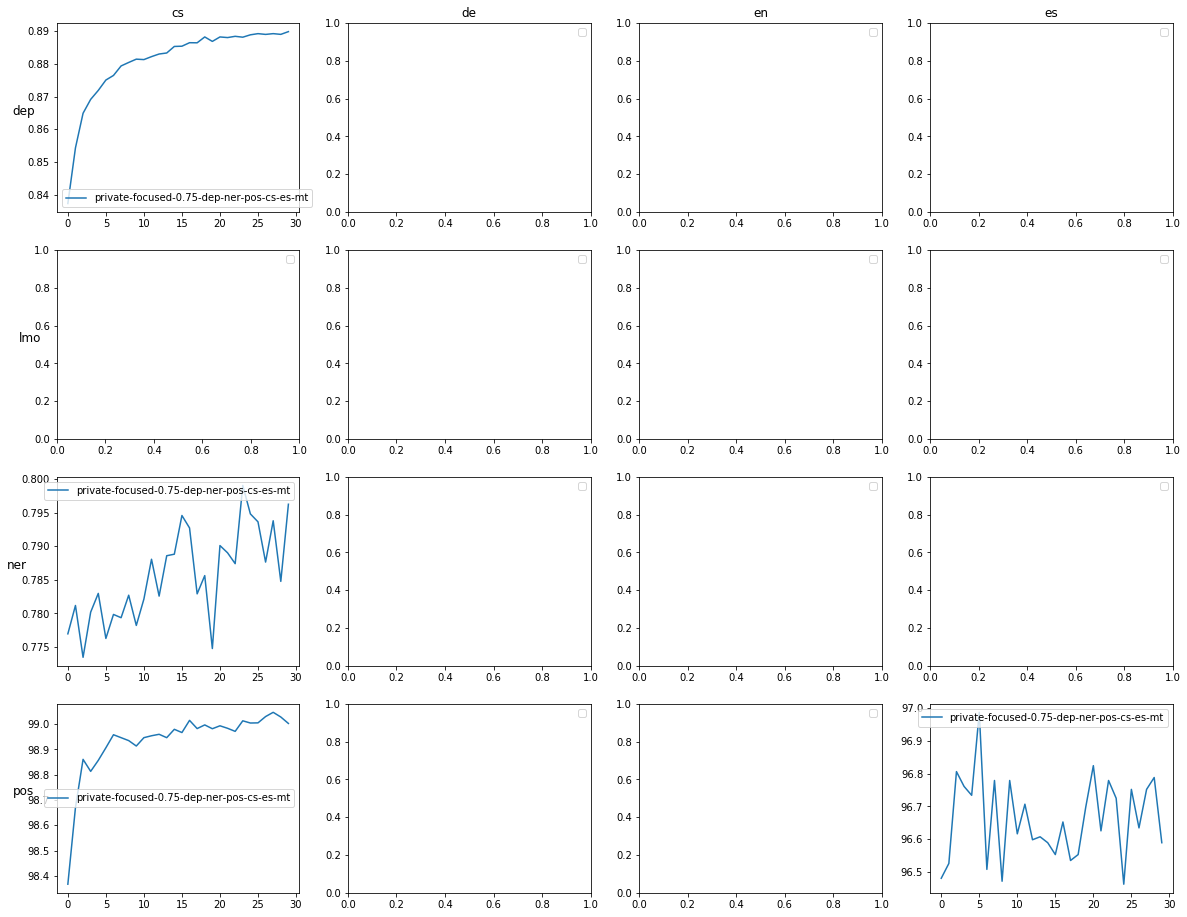

private ml dep cs: (0.8818727949993918, 29)
private mt dep cs: (0.8797988633927899, 30)
private mtml dep cs: (0.8742085170230391, 30)
private ml dep de: (0.79733054496248, 30)
private mt dep de: (0.7994218231024727, 21)
private mtml dep de: (0.7930864805019068, 24)
private ml dep en: (0.8494314733136406, 30)
private mt dep en: (0.8441306195119977, 17)
private mtml dep en: (0.8411362440820621, 26)
private ml dep es: (0.863837872070931, 28)
private mt dep es: (0.8632950330227087, 19)
private mtml dep es: (0.8556048131728943, 24)
private ml lmo cs: (1.0934995393760425, 30)
private mt lmo cs: (20.939035266329487, 30)
private mtml lmo cs: (21.867461665888925, 30)
private ml lmo de: (1.0837892014120665, 30)
private mt lmo de: (21.841272860099473, 30)
private mtml lmo de: (22.324531953948213, 30)
private ml lmo en: (1.0635896570389831, 29)
private mt lmo en: (38.33178276692361, 28)
private mtml lmo en: (39.05648536107499, 30)
private ml lmo es: (1.060616383293054, 28)
private mt lmo es: (19.6

In [5]:
draw_graphs(lambda task: task_metr[task], tasks, langs, 'test',
            [
             'private-focused-0.75-dep-ner-pos-cs-es',
            ],['mt', 'stsl'])
print_results(lambda task: task_metr[task], lambda task: task_max[task], tasks, langs, [
             'private',
            ], ['mtml', 'mt', 'ml'])

In [ ]:
draw_graphs(lambda task: task_metr[task], tasks, langs, 'test', ['vanilla'])

In [ ]:
draw_graphs(lambda task: task_metr[task], tasks, langs, 'test',
            run_codes=['vanilla', 'vanilla300', 'vanilla400'],
            run_types=['mtml'])